<a href="https://colab.research.google.com/github/jojoroy/bert/blob/main/fine_tuning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required Libraries

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


from torch.utils.data.dataset import Dataset
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/dataset_day3/Archive (15).zip'

Archive:  /content/drive/MyDrive/dataset_day3/Archive (15).zip
  inflating: new_test.csv            
  inflating: __MACOSX/._new_test.csv  
  inflating: train_set.csv           
  inflating: __MACOSX/._train_set.csv  


## Preparing the Dataset

In [ ]:
df = pd.read_csv(
    "train_set.csv",
)
df.shape

(9941, 96)

In [ ]:
df.head()

,CELEX_ID,Text,Citations,01-07,01-10,01-20,01-30,01-40,01-50,01-60,...,17-30,18,19,19-10,19-20,19-30,19-40,19-50,20-10,20-20
0,32012D0012(01),14.7.2012 EN Official Journal of the European ...,"['OJL341,22.12.2011,p.65', 'OJL331,14.12.2011,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,52018DP0022,21.12.2018 EN Official Journal of the European...,"['OJL353,31.12.2008,p.1', 'OJL208,2.8.2016,p.1...",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32020D1214(02),14.12.2020 EN Official Journal of the European...,"['OJC315I,23.9.2020,p.5', 'OJL141,27.5.2011,p.1']",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32010D1007(01),7.10.2010 EN Official Journal of the European ...,"['OJL8,12.1.2001,p.1', 'OJL196,24.7.2008,p.1',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32019D1742,21.10.2019 EN Official Journal of the European...,"['OJL128,9.5.2013,p.1', 'OJL96,31.3.2004,p.1',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding the Citatinos to the original text

In [ ]:
df['Text']= df['Text'] + df['Citations']

In [ ]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df,
    test_size=test_split,
)


print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 8946
Number of rows in test set: 995


Here we prepare the text and labels for the Train and Test Dataset

In [ ]:
# Define a list of columns that should not be chosen as label columns
not_chosen_columns = ['CELEX_ID', 'Text','Citations']

# Select label columns that are not in the list of not chosen columns
label_columns = [col for col in df.columns if col not in not_chosen_columns]

# Create a new DataFrame containing only the selected label columns
df_labels_train = train_df[label_columns]
df_labels_test = test_df[label_columns]


# Convert the label columns to lists for each row
labels_list_train = df_labels_train.values.tolist()
labels_list_test = df_labels_test.values.tolist()



Converting the integer lists inside labels_list to lists of floats

In [ ]:
# Convert integer lists inside labels_list to lists of floats
labels_list_train = [[float(label) for label in labels] for labels in labels_list_train]
labels_list_test = [[float(label) for label in labels] for labels in labels_list_test]



## Training

Fine-tuning a pretrained BERT Model on our multi label problem

In [ ]:
## TRAIN

train_texts = train_df['Text'].tolist()
train_labels = labels_list_train

eval_texts = test_df['Text'].tolist()
eval_labels = labels_list_test

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512)
eval_encodings = tokenizer(eval_texts, padding="max_length", truncation=True, max_length=512)


class TextClassifierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextClassifierDataset(train_encodings, train_labels)
eval_dataset = TextClassifierDataset(eval_encodings, eval_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=93
)



Setting the training options

In [ ]:
## TRAIN

training_arguments = TrainingArguments(
    output_dir=".",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

## Sumission

Tokenize the submission dataset, put the model on evaluation model and send to GPU if available

In [ ]:
## SUB
sub_encodings = tokenizer(sub_texts, padding="max_length", truncation=True, max_length=512)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Save the preidction tensor for the values

In [ ]:
### SAVE ALL PREDICTIONS

# List of texts to process
text_list = sub_df['Text'].tolist()

# Initialize an empty list to store probabilities
all_probabilities = []



# Process each text
for text in text_list:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities

    all_probabilities.append(probabilities)

# Now all_probabilities is a list of tensors, where each tensor contains the probabilities for a text

# You can convert all_probabilities to a NumPy array if needed
all_probabilities_array = np.array([tensor.cpu().numpy() for tensor in all_probabilities])

# You can save all_probabilities_array to a file using NumPy's save function
np.save("all_probabilities.npy", all_probabilities_array)

Take the labels with probabilites More than 0.2. (or the max if nothing is available)

In [ ]:
# Load the saved probabilities
all_probabilities_array = np.load("all_probabilities.npy")

# Define the new threshold (e.g., 0.4)
new_threshold = 0.2

# Create an empty DataFrame with the correct columns
df_submission = pd.DataFrame(columns=label_columns)

# Iterate through the rows of all_probabilities_array
for row in all_probabilities_array:
    # Create a mask for values greater than or equal to the new threshold
    mask = row >= new_threshold

    # Check if any value is above the threshold
    if mask.any():
        # If there is at least one value above the threshold, use the mask
        thresholded_row = mask.astype(int)
    else:
        # If there are no values above the threshold, take the top 1 value
        top_1_index = np.argmax(row)
        thresholded_row = np.zeros(len(label_columns), dtype=int)
        thresholded_row[top_1_index] = 1

    # Reshape the thresholded_row to match the length of the index
    thresholded_row = thresholded_row.reshape(1, -1)

    # Append the thresholded row to the DataFrame
    df_submission = df_submission.append(pd.DataFrame(thresholded_row, columns=label_columns), ignore_index=True)

# Convert the DataFrame to integer type
df_submission = df_submission.astype(int)


Plot how many rows with 1,2 or 3 labels

(array([2034.,    0.,    0.,    0.,    0.,    0.,  342.,    0.,    0.,
           0.,    0.,    0.,    0.,  105.,    0.,    0.,    0.,    0.,
           0.,    5.]),
 array([1.  , 1.15, 1.3 , 1.45, 1.6 , 1.75, 1.9 , 2.05, 2.2 , 2.35, 2.5 ,
        2.65, 2.8 , 2.95, 3.1 , 3.25, 3.4 , 3.55, 3.7 , 3.85, 4.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'Sum of Row Values')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Row Sums')

Text(1.0, 2034.0, '2034')

Text(1.15, 0.0, '0')

Text(1.3, 0.0, '0')

Text(1.45, 0.0, '0')

Text(1.6, 0.0, '0')

Text(1.75, 0.0, '0')

Text(1.9, 342.0, '342')

Text(2.05, 0.0, '0')

Text(2.2, 0.0, '0')

Text(2.3499999999999996, 0.0, '0')

Text(2.5, 0.0, '0')

Text(2.65, 0.0, '0')

Text(2.8, 0.0, '0')

Text(2.95, 105.0, '105')

Text(3.1, 0.0, '0')

Text(3.25, 0.0, '0')

Text(3.4, 0.0, '0')

Text(3.55, 0.0, '0')

Text(3.6999999999999997, 0.0, '0')

Text(3.85, 5.0, '5')

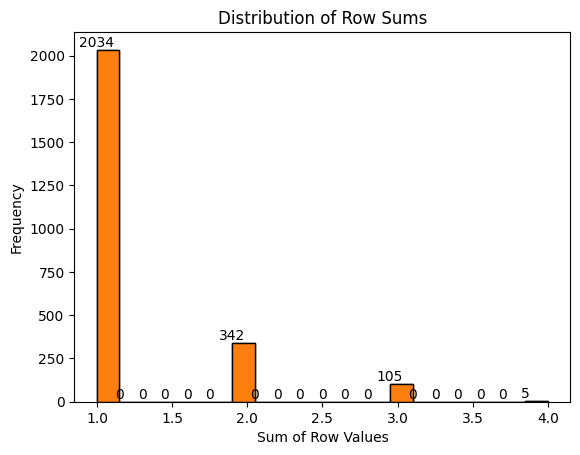

In [ ]:
# Calculate the sum of values in each row
row_sums = df_submission.sum(axis=1)

# Plot a histogram of the row sums
plt.hist(row_sums, bins=20, edgecolor='k')
plt.xlabel('Sum of Row Values')
plt.ylabel('Frequency')
plt.title('Distribution of Row Sums')

# Add text labels with the number of values in each bin
n, bins, patches = plt.hist(row_sums, bins=20, edgecolor='k')
for i in range(len(patches)):
    plt.text(bins[i], n[i], str(int(n[i])), ha='center', va='bottom')


plt.show()